# Distributed quadratic programming

This notebook presents the numerical experiments for the paper [*Private Distributed Resource Allocation Without Constraint Violations*](https://ieeexplore.ieee.org/abstract/document/11120444).

## Communication topology

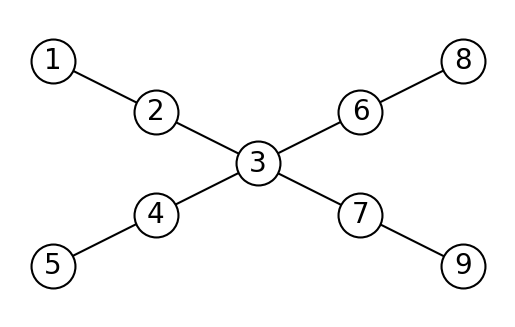

In [1]:
if __name__ == "__main__":
    NODES = ["1", "2", "3", "4", "5", "6", "7", "8", "9"]
    EDGES = [
        ("1", "2"),
        ("2", "3"),
        ("3", "4"),
        ("3", "6"),
        ("3", "7"),
        ("4", "5"),
        ("6", "8"),
        ("7", "9"),
    ]

    import networkx as nx
    import matplotlib.pyplot as plt

    G = nx.Graph()
    G.add_nodes_from(NODES)
    G.add_edges_from(EDGES)

    pos = {
        "1": [-2.0, 1.0],
        "2": [-1.0, 0.5],
        "3": [0.0, 0.0],
        "4": [-1.0, -0.5],
        "5": [-2.0, -1.0],
        "6": [1.0, 0.5],
        "7": [1.0, -0.5],
        "8": [2.0, 1.0],
        "9": [2.0, -1.0],
    }

    nx_options = {
        "with_labels": True,
        "font_size": 20,
        "node_color": "white",
        "node_size": 1000,
        "edgecolors": "black",
        "linewidths": 1.5,
        "width": 1.5,
        "pos": pos,
    }

    fig, ax = plt.subplots()
    ax.set_aspect(1)
    ax.set_ylim(-1.5, 1.5)
    nx.draw(G, ax=ax, **nx_options)

## Problem formulation:
$$
\begin{split}
    \min_{\boldsymbol{x}_{1}, \ldots, \boldsymbol{x}_{9}} \quad &\sum_{i \in \mathcal{I}}\left( \frac{1}{2}\boldsymbol{x}_{i}^{\top}Q_{i}\boldsymbol{x}_{i} + \boldsymbol{g}_{i}^{\top}\boldsymbol{x}_{i} \right)\\
    \text{s.t.} \quad
    &\begin{cases}
        \sum_{i \in \mathcal{I}}\boldsymbol{a}_{i, 1}^{\top}\boldsymbol{x}_{i} \leq b_{1}(D) \\
        \sum_{i \in \mathcal{I}}\boldsymbol{a}_{i, 2}^{\top}\boldsymbol{x}_{i} \leq b_{2}(D) \\
        \sum_{i \in \mathcal{I}}\boldsymbol{a}_{i, 3}^{\top}\boldsymbol{x}_{i} \leq b_{3}(D)
    \end{cases}
\end{split}
$$

In [2]:
if __name__ == "__main__":
    import pathlib

    script_dir = pathlib.Path.cwd()
    data_dir = script_dir / "data"

    from numpy.typing import NDArray
    import numpy as np

    db: NDArray[np.float64] = np.load(data_dir / "D.npy")

    proportion_of_1 = db[np.where(db == 1)].size / db.size
    proportion_of_2 = db[np.where(db == 2)].size / db.size
    proportion_of_3 = db[np.where(db == 3)].size / db.size

    b: NDArray[np.float64] = np.array(
        [proportion_of_1, proportion_of_2, proportion_of_3]
    )

    datas: dict[str, dict[str, NDArray[np.float64]]] = {
        i: np.load(data_dir / f"node_{i}.npz") for i in NODES
    }

    Q = {i: datas[i]["Q"] for i in NODES}
    g = {i: datas[i]["g"] for i in NODES}
    A = {i: datas[i]["A"] for i in NODES}

    import cvxpy as cp

    x: dict[str, cp.Variable] = {i: cp.Variable(A[i].shape[1]) for i in NODES}

    cost = cp.sum([x[i] @ Q[i] @ x[i] / 2 + g[i] @ x[i] for i in NODES])
    constraints: list[cp.Constraint] = [
        sum([A[i] @ x[i] for i in NODES], start=cp.Constant(0)) <= b
    ]

    problem = cp.Problem(cp.Minimize(cost), constraints)
    opt_val: float = problem.solve(solver="OSQP")  # type: ignore

    print(f"Centralized optimal value: {opt_val}")

Centralized optimal value: -60.92641675724471


### Sensitivity analysis:

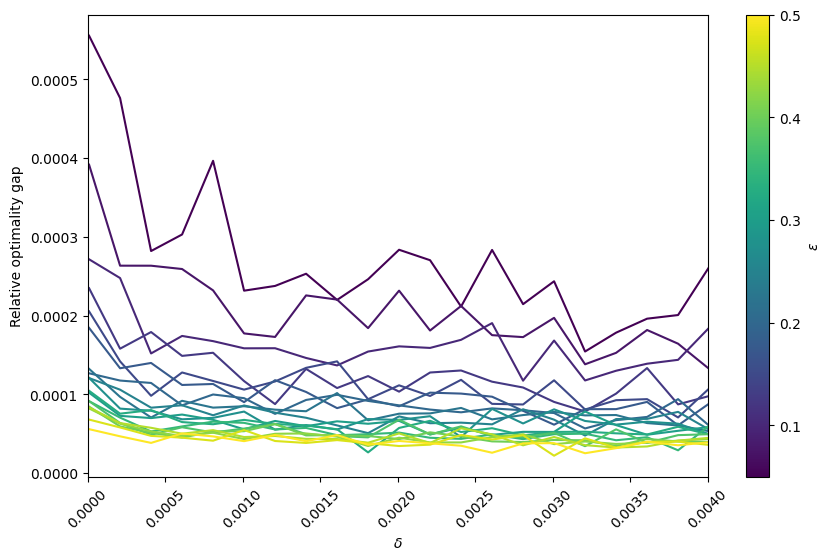

In [3]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    import numpy as np
    import cvxpy as cp
    from pdra import TruncatedLaplace

    x: dict[str, cp.Variable] = {i: cp.Variable(A[i].shape[1]) for i in NODES}
    b_bar = cp.Parameter(b.size)

    cost = cp.sum([x[i] @ Q[i] @ x[i] / 2 + g[i] @ x[i] for i in NODES])
    constraints: list[cp.Constraint] = [
        sum([A[i] @ x[i] for i in NODES], start=cp.Constant(0)) <= b_bar
    ]

    problem = cp.Problem(cp.Minimize(cost), constraints)

    epsilons = np.arange(0.05, 0.525, 0.025)
    deltas = np.arange(1e-5, 0.0042 + 1e-5, 0.0002)
    Delta = 0.002

    n_eps = epsilons.size
    n_del = deltas.size
    n_samples = n_eps * n_del
    run_times = 50

    Eps, Del = np.meshgrid(epsilons, deltas, indexing="ij")
    param_pairs = np.dstack((Eps, Del)).reshape(-1, 2)

    opt_perturb = np.zeros((n_samples, run_times))

    for i in range(n_samples):
        epsilon, delta = param_pairs[i]
        s = (Delta / epsilon) * np.log(b.size * (np.exp(epsilon) - 1) / delta + 1)
        tl = TruncatedLaplace(-s, s, 0, Delta / epsilon)

        perturbation = -s * np.ones(b.size) + tl.sample(b.size)
        b_bar.value = b + perturbation

        for j in range(run_times):
            problem.solve(solver="OSQP")
            opt_perturb[i, j] = problem.value  # type: ignore

    rel_opt_gap: NDArray[np.float64] = np.abs(
        (np.mean(opt_perturb, axis=1) - opt_val) / opt_val
    )
    rel_opt_gap = rel_opt_gap.reshape(n_eps, n_del)

    fig1, ax1 = plt.subplots(figsize=(10, 6))

    import matplotlib as mpl
    import matplotlib.cm as cm
    import matplotlib.colors as mcolors

    cmap = mpl.colormaps["viridis"]
    norm = mcolors.Normalize(vmin=epsilons.min(), vmax=epsilons.max())

    for i in range(n_eps):
        color = cmap(norm(epsilons[i]))
        ax1.plot(
            deltas,
            rel_opt_gap[i, :],
            label=f"$\\epsilon = {epsilons[i]:.2f}$",
            color=color,
        )

    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig1.colorbar(sm, ax=ax1, orientation="vertical")
    cbar.set_label("$\\epsilon$")
    ax1.set_xlim(0.0, 0.004)
    ax1.tick_params(axis="x", rotation=45)
    ax1.set_xlabel("$\\delta$")
    ax1.set_ylabel("Relative optimality gap")

## Private distributed optimization:
### Resource perturbation:

In [3]:
if __name__ == "__main__":
    import numpy as np

    algorithm = "core"  # "core" or "rsdd"

    epsilon = 0.5
    delta = 0.005
    Delta = 0.002

    np.random.seed(0)

    # Perturb b using truncated Laplace mechanism
    from pdra import TruncatedLaplace

    s = (Delta / epsilon) * np.log(b.size * (np.exp(epsilon) - 1) / delta + 1)
    tl = TruncatedLaplace(-s, s, 0, Delta / epsilon)
    perturbation = -s + tl.sample(b.size)
    safe_dra_b = b + perturbation

    # Perturb b using regular Laplace mechanism
    perturbation = np.random.laplace(0, Delta / epsilon, b.size)
    rsdd_b = b + perturbation

### Define algorithm nodes

In [11]:
from multiprocessing import Pool


def graph(nodes: list[str], edges: list[tuple[str, str]]) -> None:
    import logging

    logging.basicConfig(level=logging.INFO)

    from topolink import Graph

    graph = Graph(nodes, edges, transport="ipc")
    graph.deploy()


def safe_dra(
    node_idx: str,
    b_i: NDArray[np.float64] | None,
    step_size: float = 3.0,
    max_iter: int = 2000,
) -> dict[str, NDArray[np.float64]]:
    import pathlib
    import numpy as np

    data_dir = pathlib.Path.cwd() / "data"
    data: dict[str, NDArray[np.float64]] = np.load(data_dir / f"node_{node_idx}.npz")

    q_i = data["Q"]
    g_i = data["g"]
    a_i = data["A"]

    from topolink import NodeHandle

    nh = NodeHandle(node_idx, transport="ipc")

    from numpy import zeros

    f_i = zeros(max_iter)
    x_i = zeros((max_iter, a_i.shape[1]))
    overhead = zeros(max_iter)

    from pdra import SafeDRA

    def f(x: cp.Expression) -> cp.Expression:
        return x @ q_i @ x / 2 + g_i @ x

    algorithm = SafeDRA(nh, f, a_i, b_i=b_i, step_size=step_size)

    for k in range(max_iter):
        algorithm.step(k)
        f_i[k] = algorithm.f_i
        x_i[k] = algorithm.x_i
        overhead[k] = algorithm.overhead

    return {"f_i": f_i, "x_i": x_i, "overhead": overhead}


def rsdd(
    node_idx: str,
    b_i: NDArray[np.float64] | None,
    step_size: float = 300.0,
    max_iter: int = 2000,
    decay_rate: float = 0.9,
    penalty: float = 1e3,
) -> dict[str, NDArray[np.float64]]:
    import pathlib
    import numpy as np

    data_dir = pathlib.Path.cwd() / "data"
    data: dict[str, NDArray[np.float64]] = np.load(data_dir / f"node_{node_idx}.npz")

    q_i = data["Q"]
    g_i = data["g"]
    a_i = data["A"]

    from topolink import NodeHandle

    nh = NodeHandle(node_idx, transport="ipc")

    from numpy import zeros

    f_i = zeros(max_iter)
    x_i = zeros((max_iter, a_i.shape[1]))
    overhead = zeros(max_iter)

    from pdra.baselines import RSDD

    def f(x: cp.Expression) -> cp.Expression:
        return x @ q_i @ x / 2 + g_i @ x

    algorithm = RSDD(nh, f, a_i, None, b_i, step_size, decay_rate, penalty)

    for k in range(max_iter):
        algorithm.step(k)
        f_i[k] = algorithm.f_i
        x_i[k] = algorithm.x_i
        overhead[k] = algorithm.overhead

    return {"f_i": f_i, "x_i": x_i, "overhead": overhead}

### Run the proposed algorithm

In [12]:
if __name__ == "__main__":
    with Pool(processes=len(NODES) + 1) as pool:
        safe_dra_results = {
            i: pool.apply_async(safe_dra, args=(i, safe_dra_b if i == "1" else None))
            for i in NODES
        }
        pool.apply(graph, args=(NODES, EDGES))

        safe_dra_data = {i: res.get() for i, res in safe_dra_results.items()}

INFO:topolink.graph:Node '1' joined graph 'default' from @topolink-default-1.
INFO:topolink.graph:Node '9' joined graph 'default' from @topolink-default-9.
INFO:topolink.graph:Node '7' joined graph 'default' from @topolink-default-7.
INFO:topolink.graph:Node '6' joined graph 'default' from @topolink-default-6.
INFO:topolink.graph:Node '8' joined graph 'default' from @topolink-default-8.
INFO:topolink.graph:Node '5' joined graph 'default' from @topolink-default-5.
INFO:topolink.graph:Node '3' joined graph 'default' from @topolink-default-3.
INFO:topolink.graph:Node '2' joined graph 'default' from @topolink-default-2.
INFO:topolink.graph:Node '4' joined graph 'default' from @topolink-default-4.
INFO:topolink.graph:Graph 'default' registration complete.
INFO:topolink.graph:Sent neighbor information to all nodes in graph 'default'.


### Run RSDD

In [13]:
if __name__ == "__main__":
    with Pool(processes=len(NODES) + 1) as pool:
        rsdd_results = {
            i: pool.apply_async(rsdd, args=(i, rsdd_b if i == "1" else None))
            for i in NODES
        }
        pool.apply(graph, args=(NODES, EDGES))

        rsdd_data = {i: res.get() for i, res in rsdd_results.items()}

INFO:topolink.graph:Node '9' joined graph 'default' from @topolink-default-9.
INFO:topolink.graph:Node '1' joined graph 'default' from @topolink-default-1.
INFO:topolink.graph:Node '4' joined graph 'default' from @topolink-default-4.
INFO:topolink.graph:Node '2' joined graph 'default' from @topolink-default-2.
INFO:topolink.graph:Node '7' joined graph 'default' from @topolink-default-7.
INFO:topolink.graph:Node '5' joined graph 'default' from @topolink-default-5.
INFO:topolink.graph:Node '3' joined graph 'default' from @topolink-default-3.
INFO:topolink.graph:Node '8' joined graph 'default' from @topolink-default-8.
INFO:topolink.graph:Node '6' joined graph 'default' from @topolink-default-6.
INFO:topolink.graph:Graph 'default' registration complete.
INFO:topolink.graph:Sent neighbor information to all nodes in graph 'default'.


## Set up latex options for matplotlib:

In [7]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    plt.rcParams["text.usetex"] = True
    plt.rcParams["text.latex.preamble"] = "\\usepackage{amsmath}"
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = "Times New Roman"
    plt.rcParams["font.size"] = 15

## Results plot:
### Errors from the optimal value

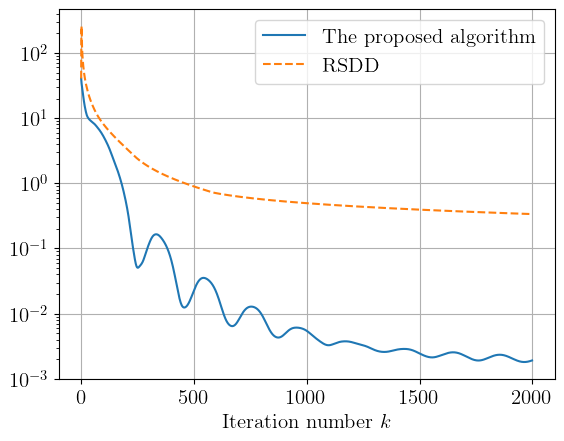

In [14]:
if __name__ == "__main__":
    fig2, ax2 = plt.subplots()

    err_safe_dra = sum([df["f_i"] for df in safe_dra_data.values()]) - opt_val
    err_rsdd = sum([df["f_i"] for df in rsdd_data.values()]) - opt_val

    ax2.plot(err_safe_dra, label="The proposed algorithm")
    ax2.plot(err_rsdd, label="RSDD", linestyle="--")

    ax2.set_xlabel("Iteration number $k$")
    ax2.set_yscale("log")
    ax2.legend()
    ax2.grid()

### Constraint values

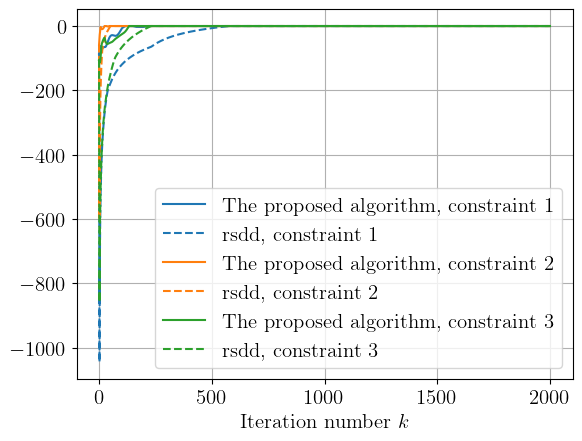

In [15]:
if __name__ == "__main__":
    fig3, ax3 = plt.subplots()

    colors = {
        "1": "tab:blue",
        "2": "tab:orange",
        "3": "tab:green",
        "4": "tab:red",
        "5": "tab:purple",
        "6": "tab:brown",
        "7": "tab:pink",
        "8": "tab:gray",
        "9": "tab:olive",
    }

    cons_vals_safe_dra = (
        np.stack([A[i] @ safe_dra_data[i]["x_i"].T for i in NODES], axis=0).sum(axis=0)
        - b[:, np.newaxis]
    )

    cons_vals_rsdd = (
        np.stack([A[i] @ rsdd_data[i]["x_i"].T for i in NODES], axis=0).sum(axis=0)
        - b[:, np.newaxis]
    )

    for j in range(3):
        ax3.plot(
            cons_vals_safe_dra[j],
            linestyle="-",
            color=colors[str(j + 1)],
            label=f"The proposed algorithm, constraint {j + 1}",
        )
        ax3.plot(
            cons_vals_rsdd[j],
            linestyle="--",
            color=colors[str(j + 1)],
            label=f"rsdd, constraint {j + 1}",
        )

    ax3.set_xlabel("Iteration number $k$")
    ax3.legend()
    ax3.grid()

### Overhead

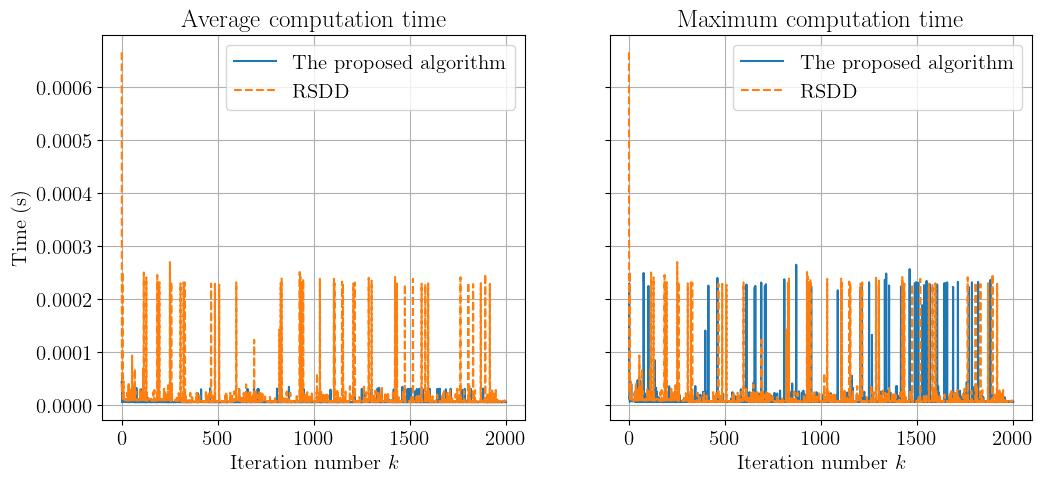

In [16]:
if __name__ == "__main__":
    fig4, ax4 = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    from matplotlib.axes import Axes

    ax4_0: Axes = ax4[0]
    ax4_1: Axes = ax4[1]

    overheads_safe_dra = np.stack([safe_dra_data[i]["overhead"] for i in NODES])
    overheads_rsdd = np.stack([rsdd_data[i]["overhead"] for i in NODES])

    avg_overheads_safe_dra = np.mean(overheads_safe_dra, axis=0)
    avg_overheads_rsdd = np.mean(overheads_rsdd, axis=0)

    max_overheads_safe_dra = np.max(overheads_safe_dra, axis=0)
    max_overheads_rsdd = np.max(overheads_rsdd, axis=0)

    # Average computation time (left)
    ax4_0.plot(
        avg_overheads_safe_dra,
        label="The proposed algorithm",
        color="tab:blue",
        linestyle="-",
    )
    ax4_0.plot(
        max_overheads_rsdd,
        label="RSDD",
        color="tab:orange",
        linestyle="--",
    )
    ax4_0.set_xlabel("Iteration number $k$")
    ax4_0.set_ylabel("Time (s)")
    ax4_0.set_title("Average computation time")
    ax4_0.legend()
    ax4_0.grid()

    # Maximum computation time (right)
    ax4_1.plot(
        max_overheads_safe_dra,
        label="The proposed algorithm",
        color="tab:blue",
        linestyle="-",
    )
    ax4_1.plot(
        max_overheads_rsdd,
        label="RSDD",
        color="tab:orange",
        linestyle="--",
    )
    ax4_1.set_xlabel("Iteration number $k$")
    ax4_1.set_title("Maximum computation time")
    ax4_1.legend()
    ax4_1.grid()

    plt.show()